In [13]:
#連結雲端
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


嘗試一次加入一個特徵值並加以觀察

**1.機器人可能會在短時間內進行大量的競標，而正常使用者的競標行為可能會更加分散:**

從"計算每個競標者在每個小時內的平均競標次數"開始並將這個值作為一個新的特徵。



In [14]:
import pandas as pd
# 讀取競標數據
df_bids = pd.read_csv('/content/drive/My Drive/bids.csv')
# 讀取訓練數據和測試數據
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
# 將時間列轉換為 datetime 類型
df_bids['time'] = pd.to_datetime(df_bids['time'])

# 創建一個新的特徵，表示每次競標的小時數
df_bids['hour'] = df_bids['time'].dt.hour

# 計算每個競標者在每個小時內的競標次數
bids_per_hour = df_bids.groupby(['bidder_id', 'hour']).size()

# 計算每個競標者每小時的平均競標次數
avg_bids_per_hour = bids_per_hour.groupby(level='bidder_id').mean()

# 將 Series 轉換為 DataFrame 並重置索引
df_avg_bids_per_hour = avg_bids_per_hour.to_frame().reset_index()

# 重命名列名
df_avg_bids_per_hour.columns = ['bidder_id', 'avg_bids_per_hour']

# 將新的特徵與訓練集和測試集進行合併
df_train = pd.merge(df_train, df_avg_bids_per_hour, on='bidder_id', how='left')
df_test = pd.merge(df_test, df_avg_bids_per_hour, on='bidder_id', how='left')


In [23]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score



# 填充缺失值為0
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

# 創建特徵（X）和目標變量（y）
X_train = df_train.drop(columns=['bidder_id', 'payment_account', 'address', 'outcome'])
y_train = df_train['outcome']

# 初始化模型
model = RandomForestClassifier(n_estimators=100, random_state=42)

# 進行交叉驗證
scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')   # 在報告後嘗試加入交叉驗證方法

# 印出平均AUC分數                                    # 用AUC來評價效果，可用於沒有Kaggle線上評分的時候
print(f"平均AUC分數: {scores.mean()}")


# 在整個訓練集上訓練模型
model.fit(X_train, y_train)

# 創建測試集的特徵
X_test = df_test.drop(columns=['bidder_id', 'payment_account', 'address'])

# 預測測試集的概率
y_test_proba = model.predict_proba(X_test)[:, 1]

# 創建一個提交結果的 DataFrame
df_submission = df_test[['bidder_id']].copy()
df_submission['prediction'] = y_test_proba

# 將提交結果寫入 CSV 文件
df_submission.to_csv('hour.csv', index=False)

print("預測結果已保存到 'hour.csv'")



平均AUC分數: 0.9175309165756288
預測結果已保存到 'hour.csv'


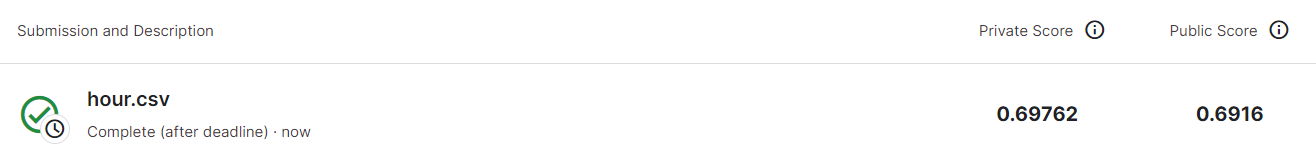

**2.機器人可能全天24小時進行競標，而正常使用者可能只在特定的時間進行競標。**

嘗試第二個特徵"每個競標者的競標時間模式"

採用的方法是計算每個競標者在每天的各個小時內進行競標的平均次數。

我們將每天24小時分成四個時段（0-6小時、6-12小時、12-18小時和18-24小時），然後計算每個競標者在每個時段的平均競標次數。



In [16]:
# 創建一個表示一天中時間（'time_of_day'）的特徵
df_bids['time_of_day'] = df_bids['hour'] // 6

# 計算每個競標者在每個時段（'time_of_day'）的競標次數
bids_per_time_of_day = df_bids.groupby(['bidder_id', 'time_of_day']).size()

# 計算每個競標者在每個時段的平均競標次數
avg_bids_per_time_of_day = bids_per_time_of_day.groupby(level='bidder_id').mean()

# 將 Series 轉換為 DataFrame 並重置索引
df_avg_bids_per_time_of_day = avg_bids_per_time_of_day.to_frame().reset_index()

# 重命名列名
df_avg_bids_per_time_of_day.columns = ['bidder_id', 'avg_bids_per_time_of_day']


In [17]:
# 將新的特徵與訓練集和測試集進行合併
df_train = pd.merge(df_train, df_avg_bids_per_time_of_day, on='bidder_id', how='left')
df_test = pd.merge(df_test, df_avg_bids_per_time_of_day, on='bidder_id', how='left')

# 填充缺失值為0
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

# 創建特徵（X）和目標變量（y）
X_train = df_train.drop(columns=['bidder_id', 'payment_account', 'address', 'outcome'])
y_train = df_train['outcome']

# 初始化模型
model = RandomForestClassifier(n_estimators=100, random_state=42)


# 在整個訓練集上訓練模型
model.fit(X_train, y_train)

# 創建測試集的特徵
X_test = df_test.drop(columns=['bidder_id', 'payment_account', 'address'])

# 預測測試集的概率
y_test_proba = model.predict_proba(X_test)[:, 1]

# 創建一個提交結果的 DataFrame
df_submission = df_test[['bidder_id']].copy()
df_submission['prediction'] = y_test_proba

# 將提交結果寫入 CSV 文件
df_submission.to_csv('range.csv', index=False)

print("預測結果已保存到 'range.csv'")


預測結果已保存到 'range.csv'


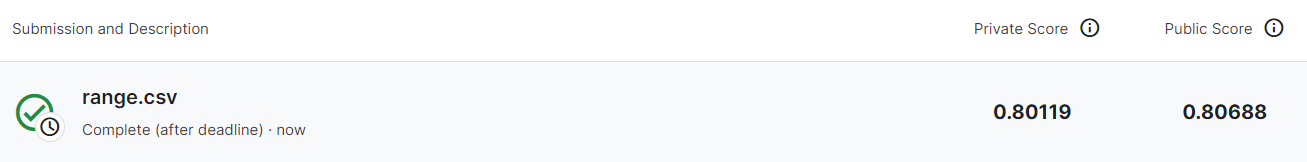

**3.機器人可能只使用一小部分的設備、IP 地址和網址，而正常使用者可能會使用更多的設備、IP 地址和網址:**

計算每個競標者使用的設備、IP地址和網址的獨特性



In [18]:
# 計算每個競標者使用的設備、IP地址和網址的數量
num_devices_per_bidder = df_bids.groupby('bidder_id')['device'].nunique()
num_ips_per_bidder = df_bids.groupby('bidder_id')['ip'].nunique()
num_urls_per_bidder = df_bids.groupby('bidder_id')['url'].nunique()

# 將 Series 轉換為 DataFrame 並重置索引
df_num_devices_per_bidder = num_devices_per_bidder.to_frame().reset_index()
df_num_ips_per_bidder = num_ips_per_bidder.to_frame().reset_index()
df_num_urls_per_bidder = num_urls_per_bidder.to_frame().reset_index()

# 重命名列名
df_num_devices_per_bidder.columns = ['bidder_id', 'num_devices']
df_num_ips_per_bidder.columns = ['bidder_id', 'num_ips']
df_num_urls_per_bidder.columns = ['bidder_id', 'num_urls']

# 合併新的特徵到訓練集和測試集
df_train = pd.merge(df_train, df_num_devices_per_bidder, on='bidder_id', how='left')
df_train = pd.merge(df_train, df_num_ips_per_bidder, on='bidder_id', how='left')
df_train = pd.merge(df_train, df_num_urls_per_bidder, on='bidder_id', how='left')

df_test = pd.merge(df_test, df_num_devices_per_bidder, on='bidder_id', how='left')
df_test = pd.merge(df_test, df_num_ips_per_bidder, on='bidder_id', how='left')
df_test = pd.merge(df_test, df_num_urls_per_bidder, on='bidder_id', how='left')

# 填充缺失值為0
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

# 創建特徵（X）和目標變量（y）
X_train = df_train.drop(columns=['bidder_id', 'payment_account', 'address', 'outcome'])
y_train = df_train['outcome']

# 初始化模型
model = RandomForestClassifier(n_estimators=100, random_state=42)

# 在整個訓練集上訓練模型
model.fit(X_train, y_train)

# 創建測試集的特徵
X_test = df_test.drop(columns=['bidder_id', 'payment_account', 'address'])

# 預測測試集的概率
y_test_proba = model.predict_proba(X_test)[:, 1]

# 創建一個提交結果的 DataFrame
df_submission = df_test[['bidder_id']].copy()
df_submission['prediction'] = y_test_proba

# 將提交結果寫入 CSV 文件
df_submission.to_csv('device.csv', index=False)

print("預測結果已保存到 'device.csv'")


預測結果已保存到 'device.csv'


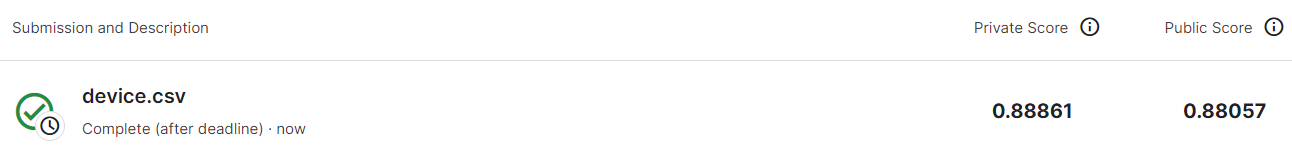

可以看到以上在分別加入三次特徵值後,模型的預測效果都有顯著的提升,而這意味著:



1. **新特徵的有效性**：這表明新加入的特徵對於我們要預測的目標變量有一定的預測力。換句話說，新的特徵與目標變量之間存在某種關聯，模型能夠利用這種關聯來提高預測的準確性。

2. **模型的學習能力**：這也表明我們的模型能夠有效地學習並利用新的特徵來進行預測。這說明我們的模型有足夠的復雜度來捕捉特徵和目標變量之間的關聯。

3. **特徵工程的重要性**：這強調了特徵工程在機器學習中的重要性。有時，通過創建新的特徵或轉換現有的特徵，我們可以顯著提高模型的性能